In [1]:
import numpy as np # 벡터, 행렬 등 수치 연산을 수행하는 선형대수 라이브러리
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리

import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시

import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import seaborn as sns

import pickle # 객체 입출력을 위한 라이브러리

from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from math import sqrt
# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, mean_squared_error, plot_confusion_matrix, classification_report

# from sklearn.preprocessing import RobustScaler # 정규화
# from sklearn.metrics import roc_curve
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import classification_report

In [2]:
X_data = pd.read_csv('../res/final_df_1.csv', index_col=0)
X_data

,pH,Temp,Voltage,QC
2021-09-06 16:29:54.000,2.15,43.15,19.74,0
2021-09-06 16:29:59.000,2.08,40.13,18.01,0
2021-09-06 16:30:04.000,2.18,43.46,18.73,0
2021-09-06 16:30:09.000,1.99,41.72,16.75,0
2021-09-06 16:30:14.000,1.85,43.65,18.02,0
...,...,...,...,...
2021-10-27 18:36:03.300,2.05,42.84,15.38,0
2021-10-27 18:36:08.300,1.91,42.64,19.08,0
2021-10-27 18:36:13.300,2.11,44.09,18.14,0
2021-10-27 18:36:18.300,1.92,43.95,17.96,0


In [3]:
X_data.shape

(50094, 4)

# 독립변수별 종속변수 간의 관계 시각화

- 어떤 독립변수가 정상/불량 결정짓는 주요 영향인자인지 그래프로 시각화

In [4]:
# 정상 데이터 모음
data_1 = X_data[(X_data['QC']==0)]
data_1

,pH,Temp,Voltage,QC
2021-09-06 16:29:54.000,2.15,43.15,19.74,0
2021-09-06 16:29:59.000,2.08,40.13,18.01,0
2021-09-06 16:30:04.000,2.18,43.46,18.73,0
2021-09-06 16:30:09.000,1.99,41.72,16.75,0
2021-09-06 16:30:14.000,1.85,43.65,18.02,0
...,...,...,...,...
2021-10-27 18:36:03.300,2.05,42.84,15.38,0
2021-10-27 18:36:08.300,1.91,42.64,19.08,0
2021-10-27 18:36:13.300,2.11,44.09,18.14,0
2021-10-27 18:36:18.300,1.92,43.95,17.96,0


In [5]:
# 불량 데이터 모음
data_0 = X_data[(X_data['QC']==1)]
data_0

,pH,Temp,Voltage,QC
2021-09-08 18:23:01.700,1.97,41.20,15.53,1
2021-09-08 18:23:06.700,2.08,42.13,16.86,1
2021-09-08 18:23:11.700,1.89,44.62,18.19,1
2021-09-08 18:23:16.700,1.95,42.55,15.59,1
2021-09-08 18:23:21.700,2.43,44.54,15.44,1
...,...,...,...,...
2021-10-25 18:00:47.800,1.88,41.14,17.21,1
2021-10-25 18:00:52.800,2.04,44.78,18.32,1
2021-10-25 18:00:57.800,2.48,41.44,16.19,1
2021-10-25 18:01:02.800,1.81,41.09,19.30,1


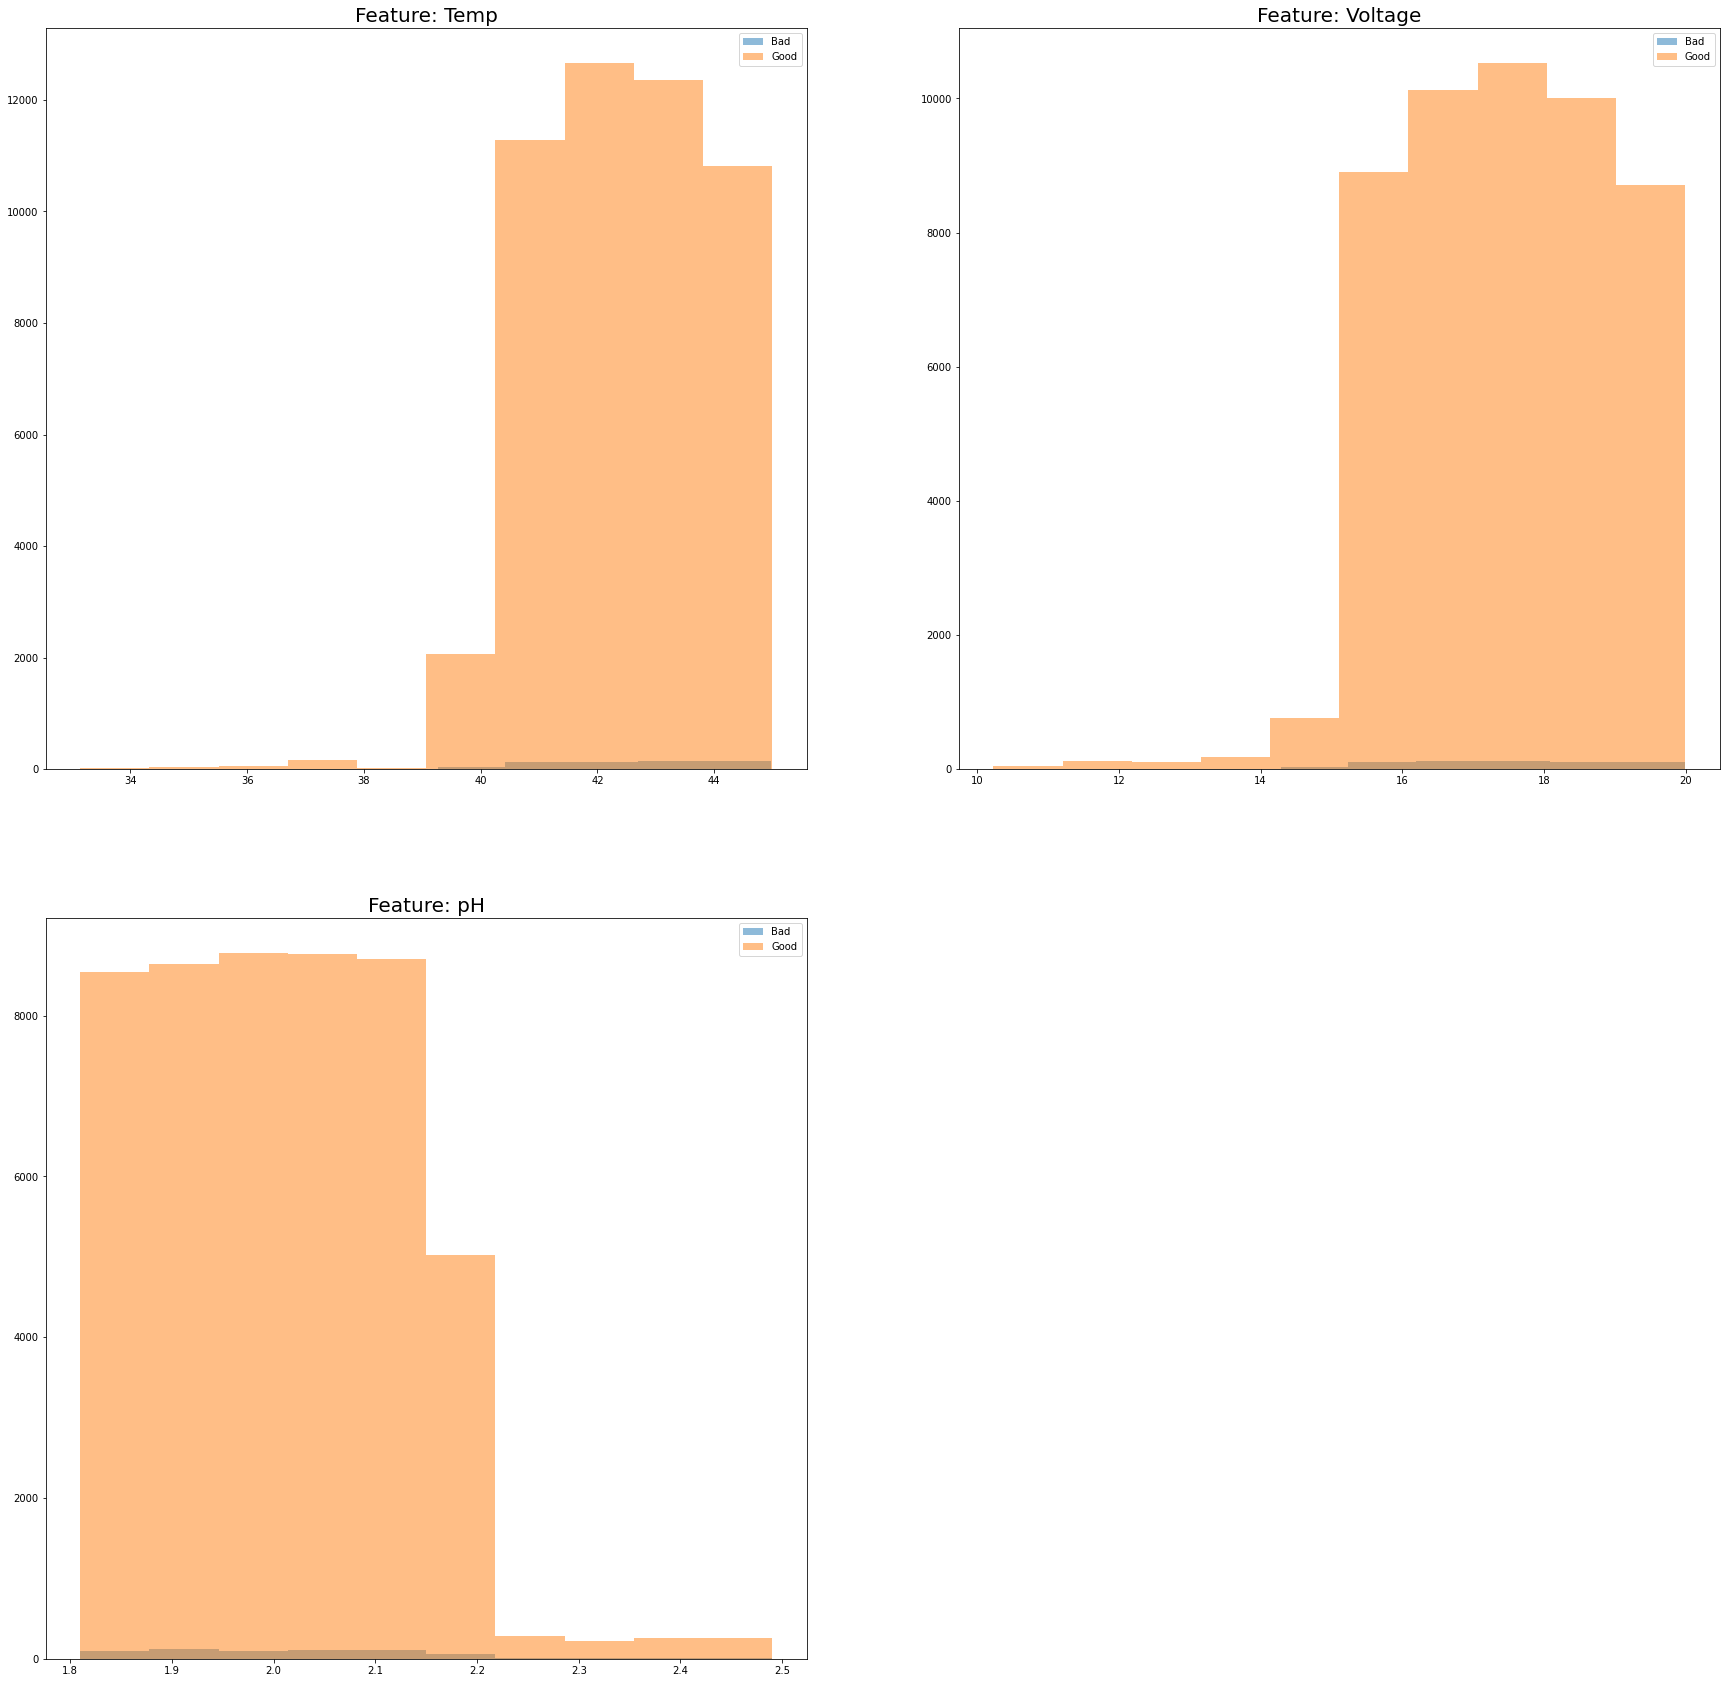

In [6]:
# 독립변수 설정
x = X_data[X_data.columns.difference(['QC'])]
# 독립변수명 리스트
feature_name = x.columns
plt.figure(figsize=(30,30))
for col_idx in range(len(feature_name)):
    # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
    # subplot(행, 열, 어디에 그릴지)
    plt.subplot(2, 2, col_idx+1)
    # 불량에 해당하는 데이터 histogram 시각화
    # alpha : 투명도
    plt.hist(X_data[X_data['QC'] == 1][feature_name[col_idx]], label = "Bad", alpha =0.5)
    # 정상에 해당하는 데이터 histogram 시각화
    plt.hist(X_data[X_data['QC'] == 0][feature_name[col_idx]], label = "Good", alpha =0.5)
    plt.legend()
    plt.title("Feature: "+ feature_name[col_idx], fontsize = 20)
plt.show()
# 시각적으로 미세한 차이가 보인다 -> 특성중요도 확인 필요

# Train/ Test Data Set Make

In [7]:
# train
train_np = X_data[['Temp', 'Voltage', 'pH']].to_numpy()
train_np

array([[43.15, 19.74,  2.15],
       [40.13, 18.01,  2.08],
       [43.46, 18.73,  2.18],
       ...,
       [44.09, 18.14,  2.11],
       [43.95, 17.96,  1.92],
       [44.11, 19.22,  1.81]])

In [8]:
# target
target_np = X_data['QC'].to_numpy()
target_np

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
# 학습용/테스트용 데이터 생성(70:30)
train_input, test_input, train_target, test_target = train_test_split(train_np, target_np, random_state=42, test_size=0.3)

In [10]:
train_input.shape

(35065, 3)

In [11]:
test_input.shape

(15029, 3)

# 모델링

In [22]:
# 정규화
scaler = StandardScaler()
train_input = scaler.fit_transform(train_input)
test_input = scaler.transform(test_input)

In [12]:
# Random Forest 모델 학습
model_1 = RFC(random_state=42, )
clf = model_1.fit(train_input, train_target)

In [13]:
clf

RandomForestClassifier(random_state=42)

In [14]:
# 훈련 정확도
clf.score(train_input, train_target)

0.9999144446028804

In [15]:
# 테스트 정확도
clf.score(test_input, test_target)

0.9874243129948765

# 모델 평가

In [16]:
clf_pred = clf.predict(test_input)
print('Random Forest Model Predict : ', clf_pred)
rmse = sqrt(mean_squared_error(test_target, clf_pred))
print('Random Forest Model RMSE : ', rmse)

Random Forest Model Predict :  [0 0 0 ... 0 0 0]
Random Forest Model RMSE :  0.11214137062263609


In [17]:
# 예측정확도 - test set로 평가
accuracy_score(test_target, clf_pred)

0.9874243129948765

In [18]:
print(classification_report(test_target, clf_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99     14840
     class 1       0.00      0.00      0.00       189

    accuracy                           0.99     15029
   macro avg       0.49      0.50      0.50     15029
weighted avg       0.98      0.99      0.98     15029



In [19]:
# Feature Importance 확인
feature_scores = pd.Series(clf.feature_importances_, index=['Temp','Voltage','pH']).sort_values(ascending=True)
feature_scores

pH         0.170296
Voltage    0.398918
Temp       0.430786
dtype: float64

<AxesSubplot:>

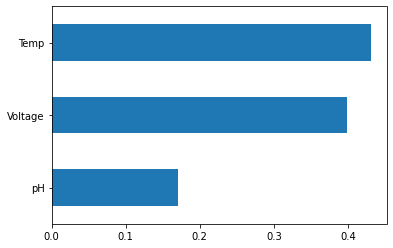

In [20]:
# feature_scores.reverse()
# plt.barh(feature_scores)
feature_scores.plot.barh()

# Classifier 모델링 함수

### 기본 모델링 함수

- 하이퍼파라미터 튜닝 없이 모델을 학습하고 성능을 평가하는 함수
- 함수는 파라미터로 알고리즘 종류, 독립변수와 종속변수의 훈련 데이터, 검증 데이터를 각각 전달받는다

In [21]:
def modeling_uncustomized(algorithm, train_input, train_target, test_input, test_target):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=42)
    uncustomized.fit(train_input, train_target)
    # Train Data 설명력
    train_score_before = uncustomized.score(train_input, train_target).round(5)
    print(f"훈련 데이터셋 정확도: {train_score_before}")
    # test Data 설명력
    test_score_before = uncustomized.score(test_input, test_target).round(5)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

## Random Forest Classifier 기반 분류 모델 성능 평가

In [22]:
# 랜덤포레스트 분류 알고리즘 : 위에 별칭
# Random Forest Classifier를 RFC로 치환
algorithm = RFC
algorithm_name = 'rfc'

### 기본 모델 학습

In [23]:
train_acc_before, val_acc_before = modeling_uncustomized(algorithm, 
                                                         train_input,
                                                         train_target,
                                                         test_input,
                                                         test_target)

# 학습 데이터셋 정확도가 1.0인 것으로 미루어 보아 과대적합 발생 예상
# 하이퍼파라미터 튜닝 필요               
# 기본 모델에서 정확도 좋게 나왔다 소수점 4자리로 했을 때 0.9999, 소수점 3자리가 정석    

훈련 데이터셋 정확도: 0.99991
테스트 데이터셋 정확도: 0.98742


### 하이퍼파라미터별 모델 성능 시각화 함수

- 하이퍼파라미터 튜닝에 따라 달라지는 모델 성능의 추이를 시각화하는 함수
- x축 : 하이퍼파라미터 값
- y축 : 학습 및 검증 데이터 기반의 모델 정확도

In [24]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 훈련 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    plt.savefig('./figure/' + algorithm_name + '_' + filename + '.png') # 시각화한 그래프는 로컬에 저장

### 모델 최적화 함수 : 학습할 트리 모델 개수 선정

- 최적의 트리 개수 결정하는 함수
- 파라미터로 입력받은 트리 개수의 최솟값부터 5개씩 최대 트리 개수까지 늘려가며 모델 성능 평가
- 앞서 작성한 시각화 함수를 호출하여 하이퍼파라미터에 따른 모델 성능 변화 추이를 시각화

In [25]:
def optimi_estimator(algorithm, algorithm_name, train_input, train_target, test_input, test_target, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=42)
        model.fit(train_input, train_target)
        train_score.append(model.score(train_input, train_target))
        test_score.append(model.score(test_input, test_target))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'testScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))

    n_estimators  TrainScore  testScore
0              5      0.9968     0.9860
1             10      0.9967     0.9870
2             15      0.9982     0.9870
3             20      0.9982     0.9872
4             25      0.9989     0.9872
5             30      0.9988     0.9873
6             35      0.9993     0.9873
7             40      0.9992     0.9874
8             45      0.9995     0.9872
9             50      0.9995     0.9874
10            55      0.9997     0.9874
11            60      0.9997     0.9875
12            65      0.9999     0.9874
13            70      0.9999     0.9874
14            75      0.9999     0.9874
15            80      0.9999     0.9874
16            85      0.9999     0.9874
17            90      0.9999     0.9874
18            95      0.9999     0.9874
19           100      0.9999     0.9874
20           105      0.9999     0.9874
21           110      0.9999     0.9874
22           115      0.9999     0.9874
23           120      0.9999     0.9874


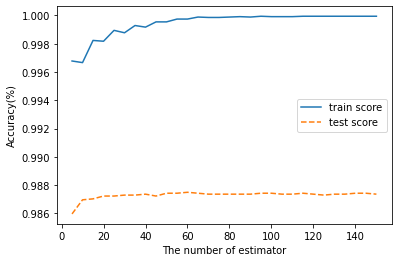

In [26]:
n_estimator_min = 1
n_estimator_max = 31
optimi_estimator(algorithm, algorithm_name, 
                 train_input, train_target, test_input, test_target, 
                 n_estimator_min, n_estimator_max)
# 트리 개수가 많고, 훈련 정확도와 테스트 정확도의 차이가 적은 값으로 선정하는 것이 좋다
# 데이터프레임과 그래프를 본 결과
# 검증 정확도가 2번째로 높고, 훈련·테스트 차이가 가장 적은 35개
# 검증 정확도가 가장 높고, 훈련·테스트 차이가 2번째로 적은 55개
# 80, 140
# 위 2가지 경우의 수로 진행
# 65로 진행
# 20!!!

In [27]:
# 1. 트리 개수 20개
n_estimator = 20

### 모델 최적화 함수 : 최대 깊이 선정

- 트리별 최대 깊이 결정하는 함수
- 파라미터로 입력받은 최대 깊이의 최솟값부터 1씩 최대 깊이의 최댓값까지 늘려가며 모델 성능 평가
- 앞서 작성한 시각화 함수를 호출하여 하이퍼파라미터에 따른 모델 성능 변화 추이를 시각화

In [28]:
def optimi_maxdepth (algorithm, algorithm_name, train_input, train_target, test_input, test_target, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=42)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=42)
        
        model.fit(train_input, train_target)
        train_score.append(model.score(train_input, train_target))
        test_score.append(model.score(test_input, test_target))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

    depth  TrainScore  TestScore
0       1      0.9877     0.9874
1       2      0.9877     0.9874
2       3      0.9877     0.9874
3       4      0.9877     0.9874
4       5      0.9878     0.9874
5       6      0.9878     0.9874
6       7      0.9879     0.9874
7       8      0.9880     0.9875
8       9      0.9880     0.9875
9      10      0.9882     0.9874
10     11      0.9886     0.9874
11     12      0.9886     0.9875
12     13      0.9890     0.9875
13     14      0.9893     0.9874
14     15      0.9898     0.9873
15     16      0.9903     0.9874
16     17      0.9904     0.9875
17     18      0.9923     0.9873
18     19      0.9930     0.9874
19     20      0.9949     0.9874


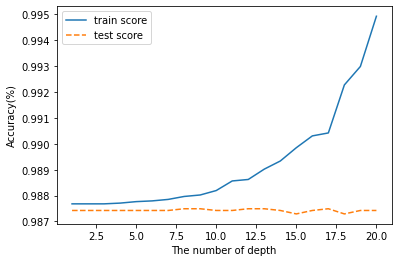

In [29]:
depth_min = 1
depth_max = 21
optimi_maxdepth(algorithm, algorithm_name, 
                train_input, train_target, test_input, test_target, 
                depth_min, depth_max, n_estimator)
# 최대 깊이는 적고 훈련 정확도와 검증 정확도의 차이가 적은 값으로 선정하는 것이 좋다
# 깊이가 깊어질수록 과대적합이 일어나기 때문에 과소적합과 과대적합이 일어나지 않는 시점인 6으로 결정
# 9!!!

    depth  TrainScore  TestScore
0       1      0.9877     0.9874
1       2      0.9877     0.9874
2       3      0.9877     0.9874
3       4      0.9877     0.9874
4       5      0.9878     0.9874
5       6      0.9878     0.9874
6       7      0.9879     0.9874
7       8      0.9880     0.9875
8       9      0.9880     0.9875
9      10      0.9882     0.9874
10     11      0.9886     0.9874
11     12      0.9886     0.9875
12     13      0.9890     0.9875
13     14      0.9893     0.9874
14     15      0.9898     0.9873
15     16      0.9903     0.9874
16     17      0.9904     0.9875
17     18      0.9923     0.9873
18     19      0.9930     0.9874
19     20      0.9949     0.9874
20     21      0.9959     0.9874
21     22      0.9969     0.9873
22     23      0.9977     0.9874
23     24      0.9979     0.9874
24     25      0.9980     0.9873
25     26      0.9981     0.9874
26     27      0.9982     0.9873
27     28      0.9983     0.9871
28     29      0.9982     0.9873
29     30 

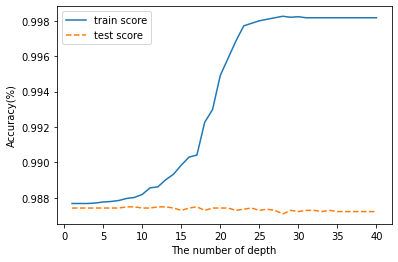

In [30]:
depth_min = 1
depth_max = 41
optimi_maxdepth(algorithm, algorithm_name, 
                train_input, train_target, test_input, test_target, 
                depth_min, depth_max, n_estimator)

In [31]:
# 2. depth = 9
n_depth = 9

### 모델 최적화 함수 : 분리 노드의 최소 자료 수 선정

- 노드 분리하기 위한 최소 자료 수 결정하는 함수
- 파라미터로 입력받은 최소 자료 수의 최솟값부터 깊이를 2씩 최소 자료 수의 최댓값까지 늘려가며 모델 성능 평가
- 앞서 작성한 시각화 함수를 호출하여 하이퍼파라미터에 따른 모델 성능 변화 추이를 시각화

In [32]:
def optimi_minsplit (algorithm, algorithm_name, train_input, train_target, test_input, test_target, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 42)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 42)
        model.fit(train_input, train_target)
        train_score.append(model.score(train_input, train_target))
        test_score.append(model.score(test_input, test_target))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

    min_samples_split  TrainScore  TestScore
0                   2      0.9880     0.9875
1                   4      0.9878     0.9874
2                   6      0.9878     0.9874
3                   8      0.9878     0.9875
4                  10      0.9878     0.9874
5                  12      0.9877     0.9874
6                  14      0.9877     0.9874
7                  16      0.9877     0.9874
8                  18      0.9877     0.9874
9                  20      0.9877     0.9874
10                 22      0.9877     0.9874
11                 24      0.9877     0.9874
12                 26      0.9877     0.9874
13                 28      0.9877     0.9874
14                 30      0.9877     0.9874
15                 32      0.9877     0.9874
16                 34      0.9877     0.9874
17                 36      0.9877     0.9874
18                 38      0.9877     0.9874
19                 40      0.9877     0.9874
20                 42      0.9877     0.9874
21        

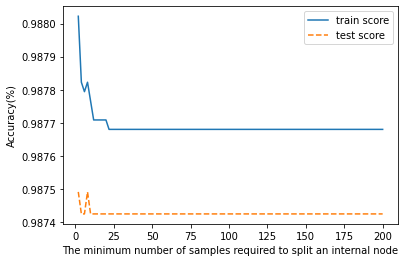

In [33]:
# depth = 9
n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 train_input, train_target, test_input, test_target,
                 n_split_min, n_split_max, n_estimator, n_depth)
# 분리 노드 최소 자료 수는 많고, 훈련 정확도와 검증 정확도 차이가 적은 값으로 선정하는 것이 좋다
# 8!!!

    min_samples_split  TrainScore  TestScore
0                   2      0.9880     0.9875
1                   4      0.9878     0.9874
2                   6      0.9878     0.9874
3                   8      0.9878     0.9875
4                  10      0.9878     0.9874
5                  12      0.9877     0.9874
6                  14      0.9877     0.9874
7                  16      0.9877     0.9874
8                  18      0.9877     0.9874
9                  20      0.9877     0.9874
10                 22      0.9877     0.9874
11                 24      0.9877     0.9874
12                 26      0.9877     0.9874
13                 28      0.9877     0.9874
14                 30      0.9877     0.9874
15                 32      0.9877     0.9874
16                 34      0.9877     0.9874
17                 36      0.9877     0.9874
18                 38      0.9877     0.9874
19                 40      0.9877     0.9874
20                 42      0.9877     0.9874
21        

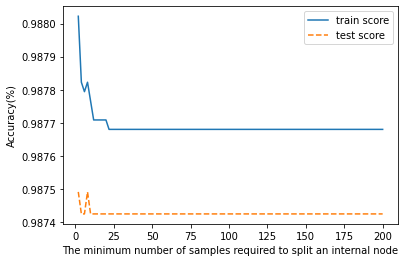

In [34]:
# depth = 8 한 번 해보기
n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 train_input, train_target, test_input, test_target,
                 n_split_min, n_split_max, n_estimator, n_depth)

In [35]:
# 3. 분리 노드 최소 자료 수
n_split = 8

### 모델 최적화 함수 : 잎사귀 노드의 최소 자료 수 선정

- 잎사귀 노드 내 최소 자료 수 결정하는 함수
- 파라미터로 입력받은 최소 자료 수의 최솟값부터 깊이를 2씩 최소 자료 수의 최댓값까지 늘려가며 모델 성능 평가
- 앞서 작성한 시각화 함수를 호출하여 하이퍼파라미터에 따른 모델 성능 변화 추이를 시각화

In [36]:
def optimi_minleaf(algorithm, algorithm_name, train_input, train_target, test_input, test_target, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=42)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=42)
        model.fit(train_input, train_target)
        train_score.append(model.score(train_input, train_target))
        test_score.append(model.score(test_input, test_target))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'ValScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

    min_samples_leaf  TrainScore  ValScore
0                  2      0.9877    0.9874
1                  4      0.9877    0.9874
2                  6      0.9877    0.9874
3                  8      0.9877    0.9874
4                 10      0.9877    0.9874
5                 12      0.9877    0.9874
6                 14      0.9877    0.9874
7                 16      0.9877    0.9874
8                 18      0.9877    0.9874
9                 20      0.9877    0.9874
10                22      0.9877    0.9874
11                24      0.9877    0.9874
12                26      0.9877    0.9874
13                28      0.9877    0.9874
14                30      0.9877    0.9874
15                32      0.9877    0.9874
16                34      0.9877    0.9874
17                36      0.9877    0.9874
18                38      0.9877    0.9874
19                40      0.9877    0.9874
20                42      0.9877    0.9874
21                44      0.9877    0.9874
22         

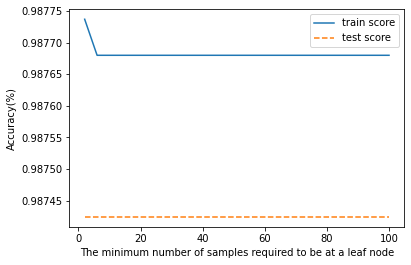

In [37]:
# n_split = 8
n_leaf_min = 1
n_leaf_max = 51
optimi_minleaf(algorithm, algorithm_name, 
               train_input, train_target, test_input, test_target, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)
# 잎사귀 노드의 최소 자료 수는 많고, 훈련 정확도와 검증 정확도의 차이가 적은 값으로 선정하는 것이 좋다
# 잎사귀 노드의 최소 자료 수가 많아질 수록 과소적합이 일어나므로 훈련·검증 정확도 차이가 나지 않는 n_leaf = 2로 선정
# 2!!!

In [38]:
# 4. 잎사귀 노드의 최소 자료 수 선정
n_leaf = 2

### 최종 모델 학습

- 앞서 구한 최적의 하이퍼파라미터를 적용하여 최종 모델 학습
- 최종 모델 pickle 모듈로 저장
- 모델 성능 평가 지표로서 Accuracy, Precision, Recall, F1 스코어, Confusion Matrix를 활용
- Feature Importance 산출 후 시각화

In [39]:
def model_final(algorithm, algorithm_name, feature_name, train_input, train_target, test_input, 
                test_target, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=42, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        print("RFC Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        model = algorithm(random_state = 42, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    # 모델 학습
    model.fit(train_input, train_target)
    # 모델 저장
    model_path = './model/'
    model_filename = 'chro_' + algorithm_name + '.pkl'
    with open(model_path + model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"최종 모델 저장 완료! 파일 경로: {model_path + model_filename}\n")
    
    # 최종 모델의 성능 평가
    train_acc = model.score(train_input, train_target)
    test_acc = model.score(test_input, test_target)
    y_pred = model.predict(test_input)
    print(f"train_acc: {train_acc:.3f}") # 훈련정확도
    print(f"Accuracy: {accuracy_score(test_target, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(test_target, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(test_target, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(test_target, y_pred):.3f}") # F1 스코어
    
    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                         test_input,test_target,
                         include_values = True,
                         display_labels = ['0', '1'], # 종속변수 이름
                         cmap = 'Pastel1') # 컬러맵
    plt.savefig('./figure/' + algorithm_name + '_confusion_matrix.png') # 혼동행렬 자료 저장
    plt.show()
    
    # 변수 중요도 산출
    dt_importance = pd.DataFrame()
    dt_importance['Feature'] = feature_name # 독립변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 독립변수 중요도 산출

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    # 변수 중요도 시각화
    coordinates = range(len(dt_importance)) # 독립변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 독립변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    plt.savefig('./figure/' + algorithm_name + '_feature_importance.png') # 변수 중요도 그래프 저장

In [40]:
cnt0 = 0
cnt1 = 0
for v in test_target :
    if v ==1 :
        cnt1 += 1
    else :
        cnt0 += 1

print(cnt0, cnt1)

14840 189


train_input =  35065
train_target =  35065
test_input =  15029
test_target =  15029
RFC Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
최종 모델 저장 완료! 파일 경로: ./model/chro_rfc.pkl

train_acc: 0.988
Accuracy: 0.987
Precision: 0.000
Recall: 0.000
F1-score: 0.000


<Figure size 2160x2160 with 0 Axes>

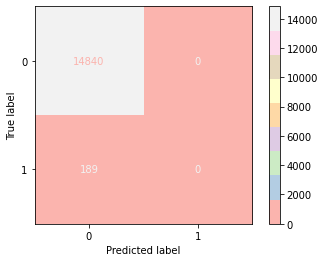

   Feature  Importance
0     Temp       0.456
1  Voltage       0.335
2       pH       0.209


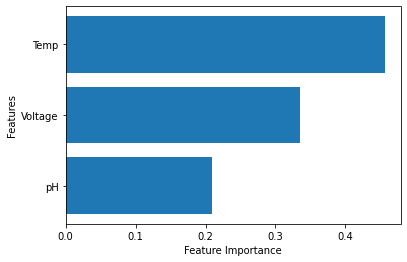

In [41]:
print("train_input = ", len(train_input))
print("train_target = ", len(train_target))
print("test_input = ", len(test_input))
print("test_target = ", len(test_target))

model_final(algorithm, algorithm_name, feature_name,
            train_input, train_target, test_input, test_target,
            n_estimator, n_depth, n_split, n_leaf)